### All notebook imports

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LSTM, BatchNormalization, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import GlobalAveragePooling1D



### Import the training data
#### I will concatenate the dataframes in the x-axis direction for the training data
to build a stream of 128 X 6 readings in each time step, i.e in each time step we
will have [gyro_x 128, gyro_x 128, gyro_z 128, acc_x 128, acc_y 128, acc_z 128 ] giving us 7352 rows × 768 columns

In [145]:
# Reads the 6 files of the training data, file paths are read 
# from the array file_paths.
def load_and_process_data(folder, train_test_identifier):
    file_paths = [f'{folder}/{sensor}_{axis}_{train_test_identifier}.txt' 
                  for sensor in ['acc', 'gyro'] 
                  for axis in ['x', 'y', 'z']]
    
    dfs = [pd.read_csv(file_path, header=None, delim_whitespace=True) for file_path in file_paths]
    df_concatenated_train = pd.concat(dfs, axis=1)
    
    return df_concatenated_train



In [146]:
train_X_folder = 'data/train/X_train'
df_concatenated_train = load_and_process_data(train_X_folder, 'train')

### Print the dataframe for visualization

In [147]:
print("Shape of training data after concatenation: ", df_concatenated_train.shape)
df_concatenated_train

Shape of training data after concatenation:  (7352, 768)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.012817,1.022833,1.022028,1.017877,1.023680,1.016974,1.017746,1.019263,1.016417,1.020745,...,-0.006042,-0.006891,-0.004903,0.001354,0.008033,0.007355,0.002669,-0.002170,-0.005643,-0.001446
1,1.018851,1.022380,1.020781,1.020218,1.021344,1.020522,1.019790,1.019216,1.018307,1.017996,...,0.016544,0.018556,0.018173,0.018046,0.019393,0.018070,0.014628,0.005045,-0.004424,-0.002798
2,1.023127,1.021882,1.019178,1.015861,1.012893,1.016451,1.020331,1.020266,1.021759,1.018649,...,-0.003351,-0.002691,-0.000283,0.000404,-0.001556,-0.001239,-0.003032,-0.005566,-0.003702,-0.002645
3,1.017682,1.018149,1.019854,1.019880,1.019121,1.020479,1.020595,1.016340,1.010611,1.009013,...,-0.009409,-0.011208,-0.013223,-0.013121,-0.012114,-0.009983,-0.007534,-0.008408,-0.011158,-0.012987
4,1.019952,1.019616,1.020933,1.023061,1.022242,1.020867,1.021939,1.022300,1.022302,1.022254,...,0.012295,0.009031,0.009103,0.005473,0.003101,0.000470,-0.006906,-0.004491,-0.003441,-0.010082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,1.374753,1.604501,1.759656,1.572037,1.202413,0.958087,0.814209,0.766668,0.848179,1.019196,...,0.033305,0.041621,0.058743,0.135576,0.137811,0.068896,0.061847,0.105364,0.192774,0.251018
7348,1.713028,1.709944,1.321608,0.970870,0.791258,0.806160,0.931817,0.955901,1.055893,1.104281,...,0.256055,0.227756,0.184920,0.193896,0.285813,0.311248,0.324083,0.319005,0.231496,0.234651
7349,0.754892,0.804314,0.831714,0.850725,0.914926,0.991363,1.080123,1.189563,1.425107,1.646699,...,0.433257,0.299354,0.181229,0.117206,0.122451,0.172516,0.201440,0.254344,0.281431,0.254206
7350,0.927927,0.912987,0.924660,0.954527,0.964228,1.011060,1.070035,1.245714,1.499556,1.575337,...,0.046540,-0.024443,-0.104694,-0.085842,-0.013465,0.083361,0.176435,0.176212,0.163561,0.188734


### we use the same function to load and concatenate the test data


In [148]:
test_X_folder = 'data/test/X_test'
df_concatenated_test = load_and_process_data(test_X_folder, 'test')

In [149]:
print("Shape of test data after concatenation: ", df_concatenated_test.shape)
df_concatenated_test

Shape of test data after concatenation:  (2947, 768)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.041216,1.041803,1.039086,1.054768,1.028376,1.006216,0.962391,0.929196,0.943047,0.951635,...,0.064141,0.064519,0.064129,0.062249,0.056800,0.049120,0.041762,0.032258,0.027008,0.030546
1,0.999192,0.994679,0.993552,0.998674,1.005490,1.003300,1.002225,1.010279,1.015780,1.019949,...,0.039078,0.039960,0.032358,0.019246,0.017810,0.035285,0.054717,0.058311,0.051000,0.036979
2,0.997593,0.998970,0.997057,0.994424,0.994056,0.993456,0.994046,0.997033,0.995975,0.994640,...,0.022114,0.026575,0.026929,0.034150,0.032427,0.024935,0.023925,0.020328,0.016454,0.014167
3,0.994564,0.994727,0.991648,0.989580,0.988147,0.987775,0.988886,0.992676,0.999319,0.999118,...,0.001784,0.000720,-0.005114,-0.006292,-0.008459,-0.014525,-0.012205,-0.011330,-0.009363,0.001263
4,0.988150,0.989711,0.987535,0.987721,0.992100,0.996465,0.997919,0.993190,0.990678,0.995205,...,0.039331,0.032300,0.016035,0.000662,-0.015730,-0.023228,-0.023526,-0.025179,-0.018610,-0.010833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,1.069760,1.085756,1.144664,1.250057,1.354189,1.406455,1.396590,1.322441,1.239165,1.111815,...,-0.666728,-0.809653,-0.930400,-0.952680,-0.908081,-0.823629,-0.699270,-0.607587,-0.625641,-0.704183
2943,0.926526,0.951442,0.983665,1.032538,1.054472,1.051729,1.068375,1.096808,1.174212,1.275978,...,0.235924,0.021526,-0.372343,-0.637858,-0.511035,-0.283016,-0.085658,0.017245,-0.157011,-0.374259
2944,0.821350,0.799200,0.800462,0.830567,0.824335,0.896028,0.928490,0.945595,0.943152,0.893586,...,0.193565,0.199671,0.225366,0.321809,0.456428,0.528796,0.273040,-0.121107,-0.210040,-0.129691
2945,1.037668,0.878073,0.896390,0.850527,0.753663,0.748222,0.693488,0.739792,0.723855,0.727170,...,0.320620,0.288623,0.320723,0.361976,0.352907,0.305887,0.252091,0.233249,0.300152,0.431867


### Import the response y for the training data


In [150]:
train_y_folder = 'data/train'
y_train = pd.read_csv(f'{train_y_folder}/y_train.txt', header=None, delim_whitespace=True)
y_train

,0
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


In [151]:
folder = 'data/test'
y_test = pd.read_csv(f'{folder}/y_test.txt', header=None, delim_whitespace=True) 
y_test

,0
0,5
1,5
2,5
3,5
4,5
...,...
2942,2
2943,2
2944,2
2945,2


In [152]:
def plot_class_imbalance(unique_classes, class_counts, activity_labels):
    plt.figure(figsize=(8, 6))
    plt.bar(unique_classes, class_counts, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Count')
    
    if activity_labels:
        plt.xticks(unique_classes, [activity_labels[label - 1] for label in unique_classes])
    else:
        plt.xticks(unique_classes)
    
    plt.show()


#### Analyse and plot the class imbalance for both the training and test data

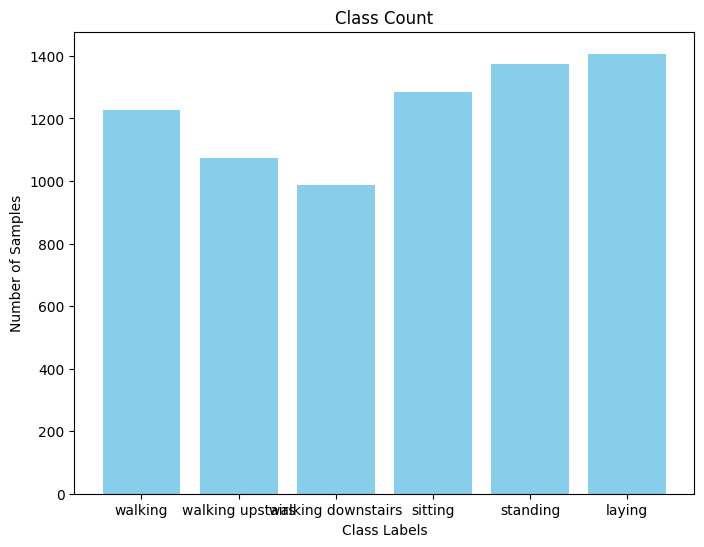

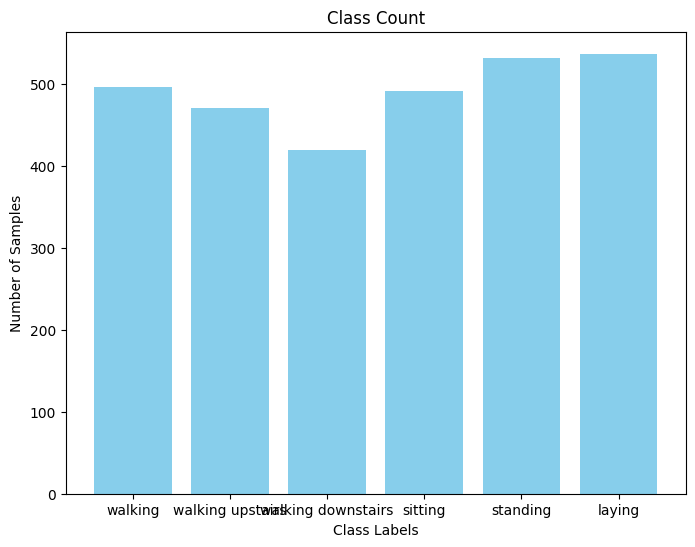

In [153]:
activities = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

# get the unique classes out of the data
unique_classes_train, class_counts_train = np.unique(y_train.values, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_test.values, return_counts=True)


# plot both training and test data
plot_class_imbalance(unique_classes_train, class_counts_train, activity_labels=activities)
plot_class_imbalance(unique_classes_test, class_counts_test, activity_labels=activities)

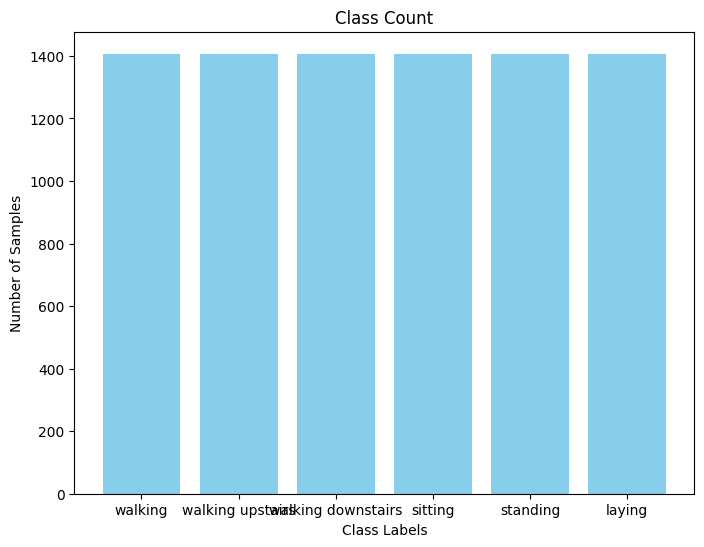

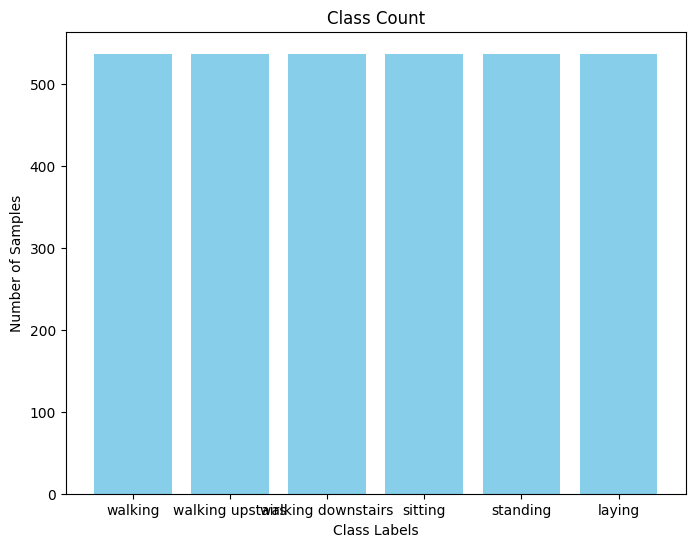

In [154]:
y_labels_train = y_train.values.ravel()
y_labels_test = y_test.values.ravel()

# oversample to balance classes for training data
oversampler = RandomOverSampler(random_state=42)
X_resampled_train, y_resampled_train = oversampler.fit_resample(df_concatenated_train.values, y_labels_train)

# oversample to balance classes for test data
oversampler = RandomOverSampler(random_state=42)
X_resampled_test, y_resampled_test = oversampler.fit_resample(df_concatenated_test.values, y_labels_test)

unique_classes_train, class_counts_train = np.unique(y_resampled_train, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_resampled_test, return_counts=True)

plot_class_imbalance(unique_classes_train, class_counts_train, activity_labels=activities)
plot_class_imbalance(unique_classes_test, class_counts_test, activity_labels=activities)


In [155]:
# one hot encode
y_train_hot_encoded = to_categorical(y_resampled_train - 1, num_classes=6) 
y_test_hot_encoded = to_categorical(y_resampled_test - 1, num_classes=6) 


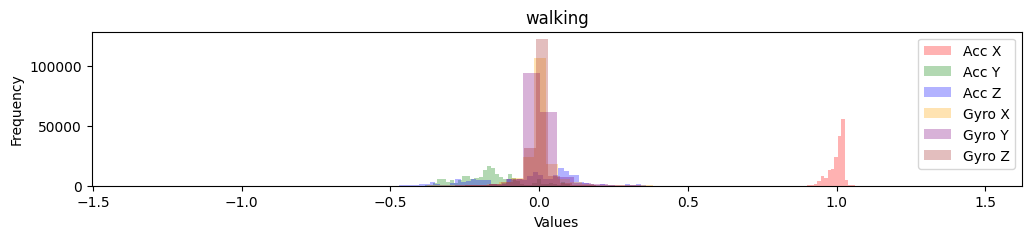

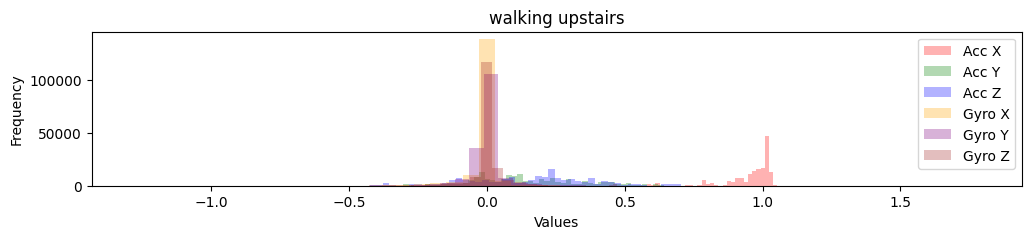

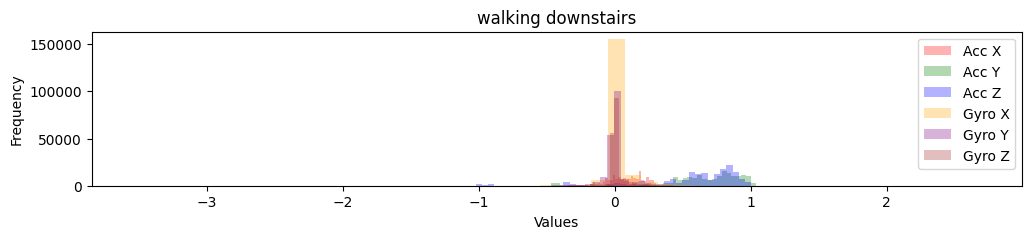

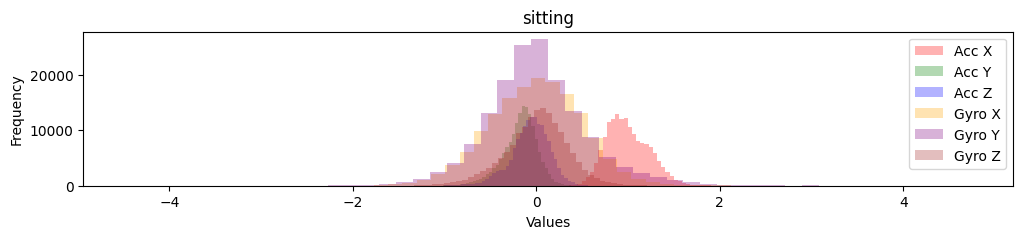

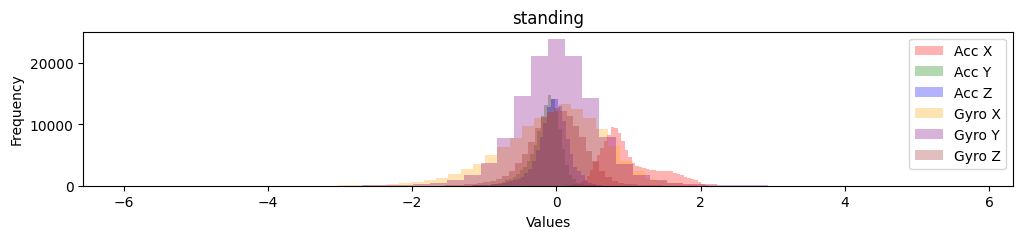

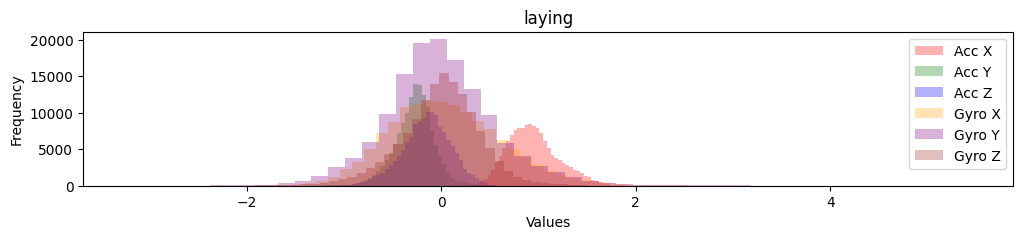

In [156]:
def plot_multiple_histograms(dataframes, labels, colors, activity):
    plt.figure(figsize=(12, 2))
    for i, (dataframe, label) in enumerate(zip(dataframes, labels)):
        color = colors[i]  
        plt.hist(dataframe.values.flatten(), bins=50, color=color, alpha=0.3, label=label)
        plt.title(activity)

    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

sensor_labels = ['Acc X', 'Acc Y', 'Acc Z', 'Gyro X', 'Gyro Y', 'Gyro Z']
file_paths = [f'data/train/X_train/{sensor}_{axis}_train.txt' 
                  for sensor in ['acc', 'gyro'] 
                  for axis in ['x', 'y', 'z']]
    
dfs = [pd.read_csv(file_path, header=None, delim_whitespace=True) for file_path in file_paths]

activity_labels = y_train[0].unique()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
activities = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing','laying']

for i, label in enumerate(activity_labels):
    activity_indices = (y_train == label).any(axis=1)
    data = [dataframe[activity_indices] for dataframe in dfs]
    plot_multiple_histograms(data, sensor_labels, colors, activities[i])


### Start with a simple Bidirectional LSTM model based on the example 
#### https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

In [157]:
### Bidirectional LSTM

scaler = MinMaxScaler()
model = Sequential()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

STEPS = 1 
FEATURES = 768

# I load the values of y_test and y_train that I hot
# encoded in the y_train and y_test varaibles
y_train = np.array(y_train_hot_encoded)
y_test = np.array(y_test_hot_encoded)

# Make sure that we normalize the resampled training and test data after the oversampling
X_train_normalized = scaler.fit_transform(X_resampled_train)
X_test_normalized = scaler.fit_transform(X_resampled_test)

# reshape the arrays for model traininig
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], STEPS, FEATURES)
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], STEPS, FEATURES)


model.add(
    Bidirectional(
      LSTM(
          units=128,
          input_shape=(STEPS, FEATURES),
          return_sequences=False  
      )
    )
)
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))


optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/100
106/106 [==============================] - 2s 6ms/step - loss: 1.7039 - accuracy: 0.3436 - val_loss: 1.8184 - val_accuracy: 0.1314
Epoch 2/100
106/106 [==============================] - 0s 3ms/step - loss: 1.5949 - accuracy: 0.3877 - val_loss: 1.7660 - val_accuracy: 0.1824
Epoch 3/100
106/106 [==============================] - 0s 3ms/step - loss: 1.4999 - accuracy: 0.4265 - val_loss: 1.7051 - val_accuracy: 0.2049
Epoch 4/100
106/106 [==============================] - 0s 3ms/step - loss: 1.4278 - accuracy: 0.4426 - val_loss: 1.6546 - val_accuracy: 0.2274
Epoch 5/100
106/106 [==============================] - 0s 3ms/step - loss: 1.3727 - accuracy: 0.4645 - val_loss: 1.6335 - val_accuracy: 0.2345
Epoch 6/100
106/106 [==============================] - 0s 3ms/step - loss: 1.3333 - accuracy: 0.4746 - val_loss: 1.5928 - val_accuracy: 0.2351
Epoch 7/100
106/106 [==============================] - 0s 3ms/step - loss: 1.2993 - accuracy: 0.4879 - val_loss: 1.5520 - val_accuracy: 0.2451

Epoch 58/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9916 - accuracy: 0.5858 - val_loss: 1.2759 - val_accuracy: 0.3837
Epoch 59/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9894 - accuracy: 0.5763 - val_loss: 1.2958 - val_accuracy: 0.3724
Epoch 60/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9859 - accuracy: 0.5869 - val_loss: 1.2620 - val_accuracy: 0.4002
Epoch 61/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9863 - accuracy: 0.5820 - val_loss: 1.2543 - val_accuracy: 0.4233
Epoch 62/100
106/106 [==============================] - 0s 4ms/step - loss: 0.9854 - accuracy: 0.5830 - val_loss: 1.2766 - val_accuracy: 0.3825
Epoch 63/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9850 - accuracy: 0.5857 - val_loss: 1.2704 - val_accuracy: 0.3813
Epoch 64/100
106/106 [==============================] - 0s 3ms/step - loss: 0.9822 - accuracy: 0.5888 - val_loss: 1.2699 - val_accuracy:

In [158]:
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)

loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Final Training Loss: 0.9651864171028137
Final Training Accuracy: 0.594994843006134
101/101 [==============================] - 0s 833us/step - loss: 1.1479 - accuracy: 0.5264
Test Loss: 1.1478605270385742
Test Accuracy: 0.5263811349868774


In [159]:
predictions = model.predict(X_test_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')

101/101 [==============================] - 0s 884us/step
Weighted Precision: 0.5053882729607824
Weighted Recall: 0.526381129733085


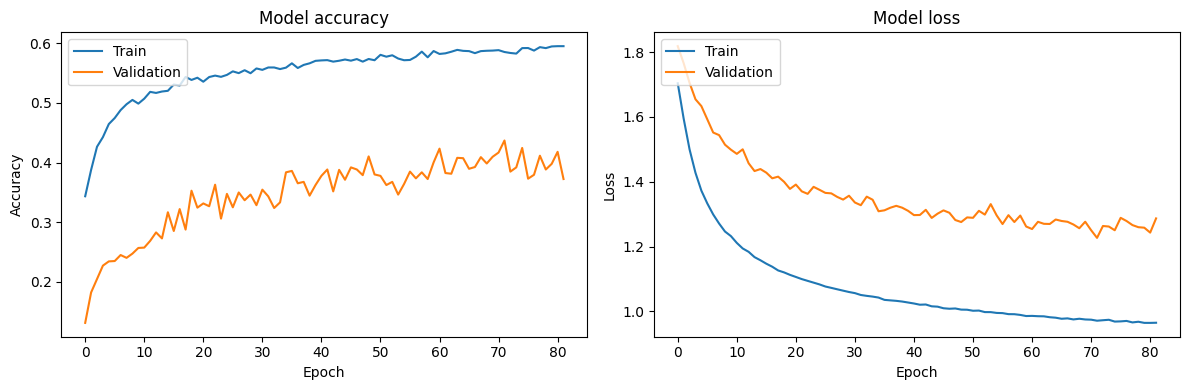

In [160]:
# trainining and validation acc
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# trainining and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

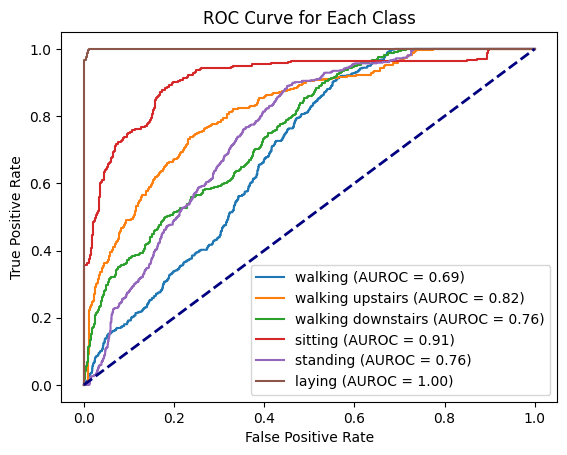

In [161]:

auroc_values = []
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing','laying']
for i in range(len(classes)): 
    binary_true_labels = (y_test[:, i] == 1).astype(int)
    predicted_probabilities = predictions[:, i]
    fpr, tpr, _ = roc_curve(binary_true_labels, predicted_probabilities)
    auroc = roc_auc_score(binary_true_labels, predicted_probabilities)
    auroc_values.append(auroc)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUROC = {auroc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()



101/101 [==============================] - 0s 868us/step


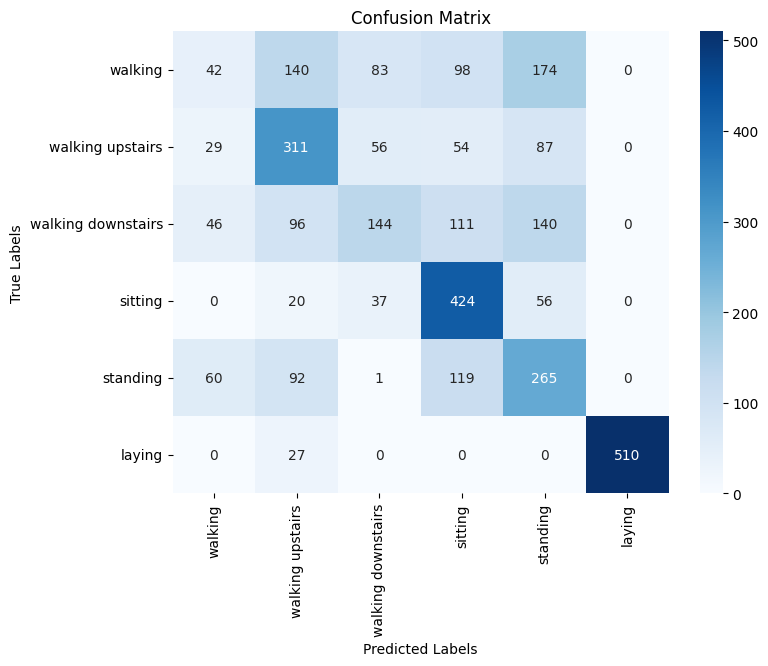

In [162]:
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

y_test_int = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_int, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [163]:
total_misclassifications = np.sum(conf_matrix) - np.trace(conf_matrix)
print("Total misclassifications:", total_misclassifications)

Total misclassifications: 1526


### Add convolutional layer for added model complexity since the initial  model is underfitting

In [164]:
### CNN nad Bidirectional LSTM combined

scaler = MinMaxScaler()
model = Sequential()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

STEPS = 1 
FEATURES = 768

# I loaded the values of y_test and y_train that I hot
# encoded in the y_train and y_test varaibles
y_train = np.array(y_train_hot_encoded)
y_test = np.array(y_test_hot_encoded)

# Make sure that we normalize the resampled training and test data after the oversampling
X_train_normalized = scaler.fit_transform(X_resampled_train)
X_test_normalized = scaler.fit_transform(X_resampled_test)

# reshape the arrays for model traininig
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], STEPS, FEATURES)
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], STEPS, FEATURES)


model.add(
    Bidirectional(
      LSTM(
          units=128,
          input_shape=[STEPS, FEATURES],
          return_sequences=True  
      )
    )
)
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))


optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=150, batch_size=64, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/150
106/106 [==============================] - 2s 6ms/step - loss: 2.0567 - accuracy: 0.2762 - val_loss: 1.7732 - val_accuracy: 0.1983
Epoch 2/150
106/106 [==============================] - 0s 4ms/step - loss: 1.7139 - accuracy: 0.3684 - val_loss: 1.7311 - val_accuracy: 0.2445
Epoch 3/150
106/106 [==============================] - 0s 4ms/step - loss: 1.5609 - accuracy: 0.4060 - val_loss: 1.6660 - val_accuracy: 0.2729
Epoch 4/150
106/106 [==============================] - 0s 4ms/step - loss: 1.4469 - accuracy: 0.4308 - val_loss: 1.5965 - val_accuracy: 0.2356
Epoch 5/150
106/106 [==============================] - 0s 4ms/step - loss: 1.3775 - accuracy: 0.4521 - val_loss: 1.5060 - val_accuracy: 0.2818
Epoch 6/150
106/106 [==============================] - 0s 4ms/step - loss: 1.3098 - accuracy: 0.4792 - val_loss: 1.4699 - val_accuracy: 0.2883
Epoch 7/150
106/106 [==============================] - 0s 4ms/step - loss: 1.2655 - accuracy: 0.4857 - val_loss: 1.5014 - val_accuracy: 0.2795

Epoch 58/150
106/106 [==============================] - 0s 4ms/step - loss: 0.5168 - accuracy: 0.8193 - val_loss: 0.5384 - val_accuracy: 0.8135
Epoch 59/150
106/106 [==============================] - 0s 4ms/step - loss: 0.4961 - accuracy: 0.8263 - val_loss: 0.5096 - val_accuracy: 0.8366
Epoch 60/150
106/106 [==============================] - 0s 4ms/step - loss: 0.5104 - accuracy: 0.8238 - val_loss: 0.5009 - val_accuracy: 0.8242
Epoch 61/150
106/106 [==============================] - 0s 4ms/step - loss: 0.4956 - accuracy: 0.8313 - val_loss: 0.5238 - val_accuracy: 0.8206
Epoch 62/150
106/106 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.8301 - val_loss: 0.5104 - val_accuracy: 0.8200
Epoch 63/150
106/106 [==============================] - 0s 4ms/step - loss: 0.4909 - accuracy: 0.8262 - val_loss: 0.4986 - val_accuracy: 0.8200
Epoch 64/150
106/106 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.8269 - val_loss: 0.4793 - val_accuracy:

Epoch 115/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3340 - accuracy: 0.8875 - val_loss: 0.3099 - val_accuracy: 0.8970
Epoch 116/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3260 - accuracy: 0.8897 - val_loss: 0.3047 - val_accuracy: 0.9082
Epoch 117/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3087 - accuracy: 0.9006 - val_loss: 0.3045 - val_accuracy: 0.9005
Epoch 118/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3205 - accuracy: 0.8913 - val_loss: 0.3090 - val_accuracy: 0.8905
Epoch 119/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3118 - accuracy: 0.8962 - val_loss: 0.2982 - val_accuracy: 0.8970
Epoch 120/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3140 - accuracy: 0.8923 - val_loss: 0.3062 - val_accuracy: 0.8934
Epoch 121/150
106/106 [==============================] - 0s 4ms/step - loss: 0.3195 - accuracy: 0.8898 - val_loss: 0.3117 - val_ac

In [165]:
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)

loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Final Training Loss: 0.2687344253063202
Final Training Accuracy: 0.9083370566368103
101/101 [==============================] - 0s 1ms/step - loss: 0.6387 - accuracy: 0.7921
Test Loss: 0.6387409567832947
Test Accuracy: 0.7920546531677246


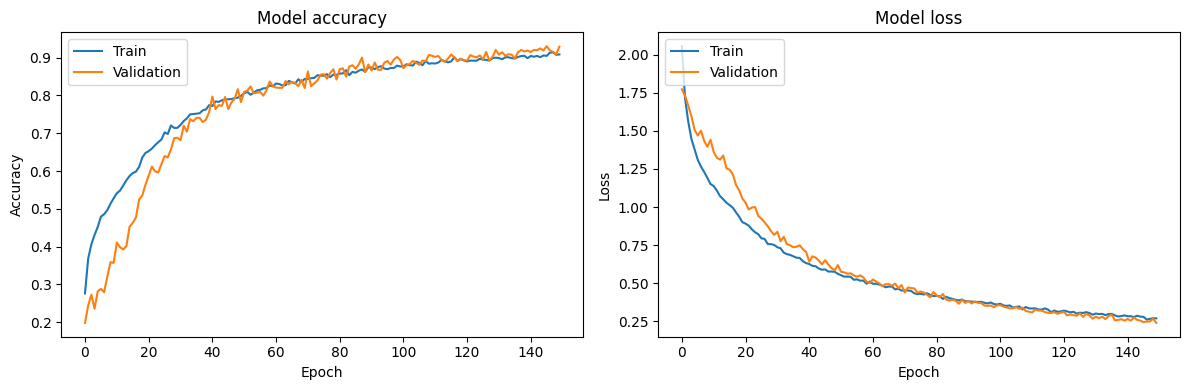

In [166]:
# trainining and validation acc
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# trainining and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [167]:
predictions = model.predict(X_test_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')

101/101 [==============================] - 0s 1ms/step
Weighted Precision: 0.8318626072244147
Weighted Recall: 0.7920546244568591


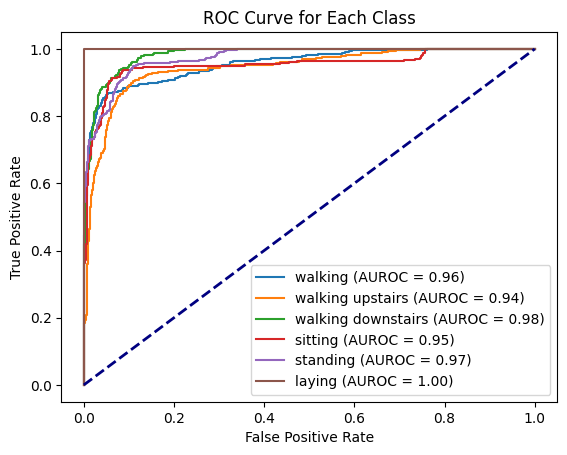

In [168]:

auroc_values = []
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing','laying']
for i in range(len(classes)):  
    binary_true_labels = (y_test[:, i] == 1).astype(int)
    predicted_probabilities = predictions[:, i]
    fpr, tpr, _ = roc_curve(binary_true_labels, predicted_probabilities)
    auroc = roc_auc_score(binary_true_labels, predicted_probabilities)
    auroc_values.append(auroc)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUROC = {auroc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()



101/101 [==============================] - 0s 1ms/step


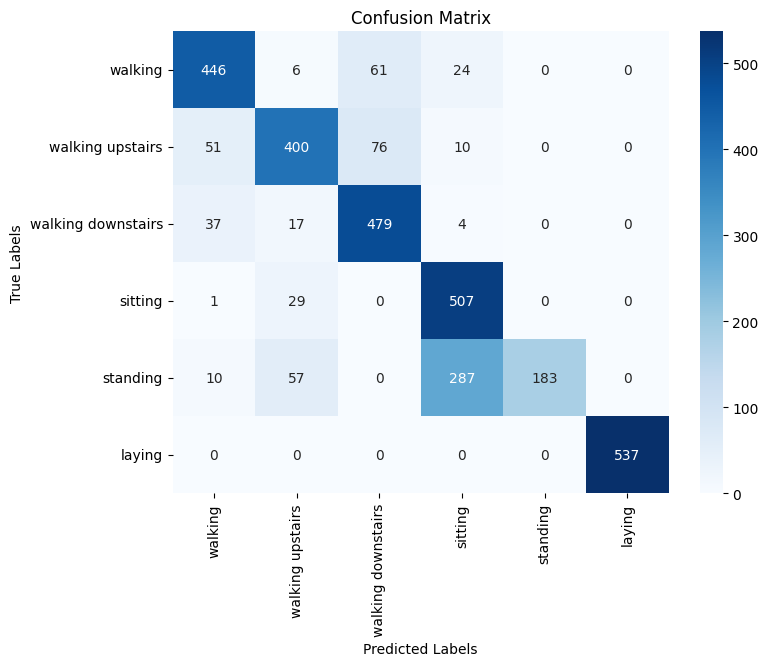

In [169]:
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

y_test_int = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_int, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [170]:
total_misclassifications = np.sum(conf_matrix) - np.trace(conf_matrix)
print("Total misclassifications:", total_misclassifications)

Total misclassifications: 670


In [171]:
### Add even more block of convolution, tune the hyper parameters

In [172]:
### CNN nad Bidirectional LSTM combined

scaler = MinMaxScaler()
model = Sequential()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

STEPS = 1 
FEATURES = 768

# I load the values of y_test and y_train that I hot
# encoded in the y_train and y_test varaibles
y_train = np.array(y_train_hot_encoded)
y_test = np.array(y_test_hot_encoded)

# Make sure that we normalize the resampled training and test data after the oversampling
X_train_normalized = scaler.fit_transform(X_resampled_train)
X_test_normalized = scaler.fit_transform(X_resampled_test)

# reshape the arrays for model traininig
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], STEPS, FEATURES)
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], STEPS, FEATURES)


model.add(
    Bidirectional(
      LSTM(
          units=128,
          input_shape=[STEPS, FEATURES],
          return_sequences=True  
      )
    )
)
model.add(
    Bidirectional(
      LSTM(
          units=64,
          return_sequences=True  
      )
    )
)
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dropout(0.1))


model.add(Dense(6, activation='softmax'))


optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=150, batch_size=64, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/150
106/106 [==============================] - 4s 13ms/step - loss: 1.4682 - accuracy: 0.4311 - val_loss: 1.7919 - val_accuracy: 0.1338
Epoch 2/150
106/106 [==============================] - 1s 5ms/step - loss: 1.2368 - accuracy: 0.5880 - val_loss: 1.7893 - val_accuracy: 0.2114
Epoch 3/150
106/106 [==============================] - 1s 6ms/step - loss: 1.1616 - accuracy: 0.6216 - val_loss: 1.7849 - val_accuracy: 0.3422
Epoch 4/150
106/106 [==============================] - 1s 5ms/step - loss: 1.1161 - accuracy: 0.6394 - val_loss: 1.7770 - val_accuracy: 0.4298
Epoch 5/150
106/106 [==============================] - 1s 5ms/step - loss: 1.0677 - accuracy: 0.6736 - val_loss: 1.7644 - val_accuracy: 0.4737
Epoch 6/150
106/106 [==============================] - 1s 5ms/step - loss: 1.0339 - accuracy: 0.6837 - val_loss: 1.7398 - val_accuracy: 0.5388
Epoch 7/150
106/106 [==============================] - 1s 5ms/step - loss: 0.9988 - accuracy: 0.6973 - val_loss: 1.6988 - val_accuracy: 0.555

Epoch 58/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3522 - accuracy: 0.9171 - val_loss: 0.3391 - val_accuracy: 0.9177
Epoch 59/150
106/106 [==============================] - 1s 6ms/step - loss: 0.3484 - accuracy: 0.9171 - val_loss: 0.3365 - val_accuracy: 0.9218
Epoch 60/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3426 - accuracy: 0.9186 - val_loss: 0.3349 - val_accuracy: 0.9183
Epoch 61/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3391 - accuracy: 0.9197 - val_loss: 0.3348 - val_accuracy: 0.9213
Epoch 62/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3309 - accuracy: 0.9214 - val_loss: 0.3080 - val_accuracy: 0.9402
Epoch 63/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3277 - accuracy: 0.9239 - val_loss: 0.3126 - val_accuracy: 0.9207
Epoch 64/150
106/106 [==============================] - 1s 5ms/step - loss: 0.3203 - accuracy: 0.9236 - val_loss: 0.3199 - val_accuracy:

Epoch 115/150
106/106 [==============================] - 1s 5ms/step - loss: 0.2006 - accuracy: 0.9455 - val_loss: 0.1778 - val_accuracy: 0.9586
Epoch 116/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1920 - accuracy: 0.9479 - val_loss: 0.1749 - val_accuracy: 0.9591
Epoch 117/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1949 - accuracy: 0.9464 - val_loss: 0.1814 - val_accuracy: 0.9485
Epoch 118/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1970 - accuracy: 0.9468 - val_loss: 0.1616 - val_accuracy: 0.9615
Epoch 119/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1932 - accuracy: 0.9483 - val_loss: 0.1878 - val_accuracy: 0.9449
Epoch 120/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1919 - accuracy: 0.9485 - val_loss: 0.1812 - val_accuracy: 0.9538
Epoch 121/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1902 - accuracy: 0.9473 - val_loss: 0.1608 - val_ac

In [173]:
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)

loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Final Training Loss: 0.1617700755596161
Final Training Accuracy: 0.9493558406829834
101/101 [==============================] - 0s 1ms/step - loss: 0.5809 - accuracy: 0.8330
Test Loss: 0.5809129476547241
Test Accuracy: 0.833022952079773


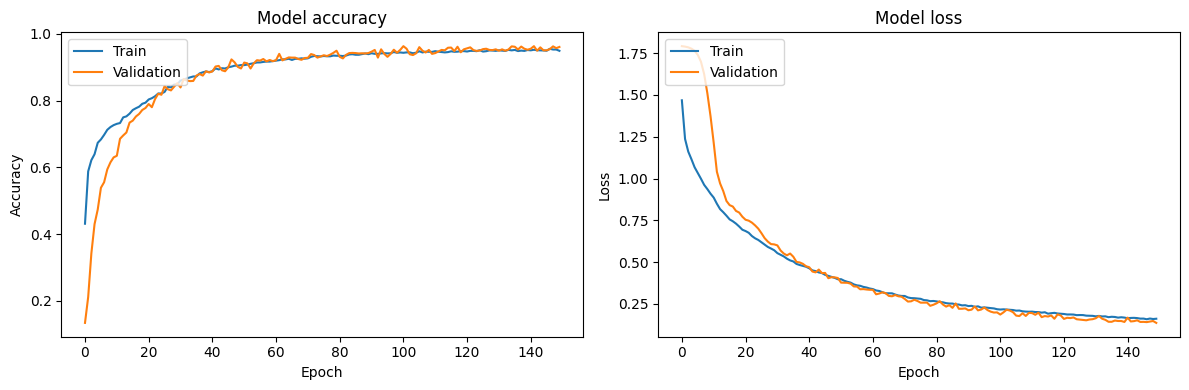

In [174]:
# trainining and validation acc
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# trainining and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [175]:
predictions = model.predict(X_test_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
recall = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')

101/101 [==============================] - 1s 1ms/step
Weighted Precision: 0.869006617650455
Weighted Recall: 0.8330229671011794


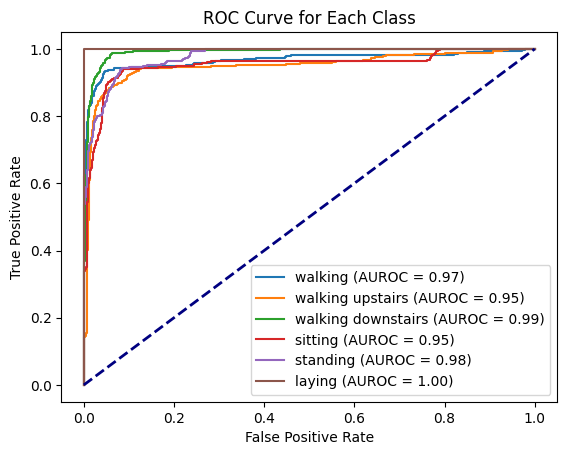

In [176]:

auroc_values = []
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing','laying']
for i in range(len(classes)):
    binary_true_labels = (y_test[:, i] == 1).astype(int)
    predicted_probabilities = predictions[:, i]
    fpr, tpr, _ = roc_curve(binary_true_labels, predicted_probabilities)
    auroc = roc_auc_score(binary_true_labels, predicted_probabilities)
    auroc_values.append(auroc)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUROC = {auroc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()



101/101 [==============================] - 0s 1ms/step


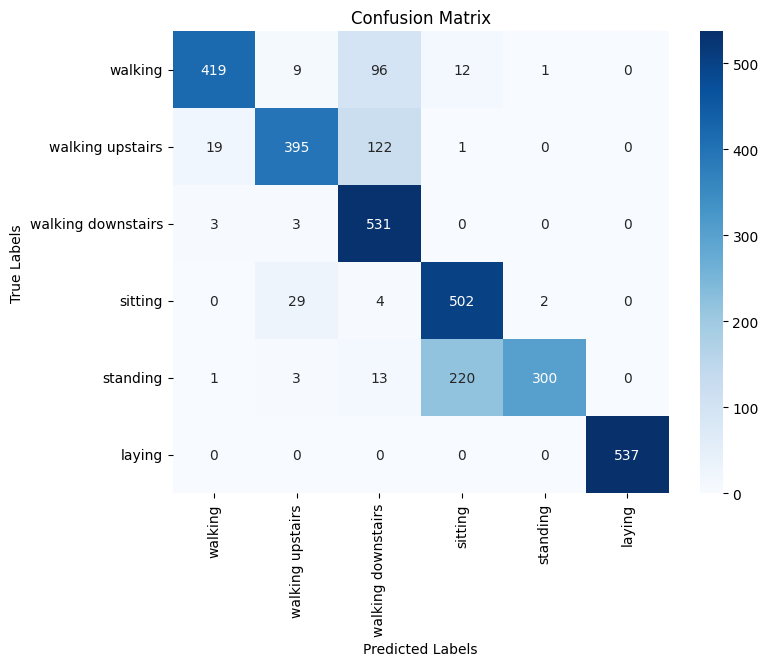

In [177]:
classes = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

y_test_int = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_int, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [178]:
total_misclassifications = np.sum(conf_matrix) - np.trace(conf_matrix)
print("Total misclassifications:", total_misclassifications)

Total misclassifications: 538
